## Business Understanding
- Goal: Cluster the feature provided from dataset.

In [1]:
import findspark
import pyspark
findspark.init()

In [2]:
# import libraries
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

import pandas as pd
import numpy as np
import pandas_profiling as pp

import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from datetime import datetime
from pyspark.sql.functions import *
from pyspark.sql import types 
from pyspark.sql.types import *
from pyspark.ml.feature import *

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer, Tokenizer, StopWordsRemover, CountVectorizer, IDF, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [3]:
sc = SparkContext()

In [4]:
spark = SparkSession.builder.appName('cluster').getOrCreate()

## Data loading

In [5]:
news = spark.read.csv('news.csv', header = True, inferSchema = True)

In [6]:
news.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- authors: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- text: string (nullable = true)
 |-- url: string (nullable = true)



In [7]:
print('Total row & column of the dataset:', news.count(), 'rows and', len(news.columns), 'columns')

Total row & column of the dataset: 3566 rows and 7 columns


In [8]:
for row in news.take(3):
    print(row)
    print('\n')

Row(_c0=0, authors="['Cbc News']", title="Coronavirus a 'wake-up call' for Canada's prescription drug supply", publish_date='2020-03-27 08:00:00', description='Canadian pharmacies are limiting how much medication can be dispensed to try to prevent shortages, recognizing that most active ingredients for drugs come from India and China and medical supply chains have been disrupted by the spread of COVID-19.', text='"Canadian pharmacies are limiting how much medication can be dispensed to try to prevent shortages, recognizing that most active ingredients for drugs come from India and China and medical supply chains have been disrupted by the spread of COVID-19. Provincial regulatory colleges are complying with the Canadian Pharmacists Association call to limit the amount of medications given to patients to 30-day\xa0supplies. The goal is to stop people from refilling prescriptions early and to ensure life-saving drugs don\'t run short when supply chains are\xa0vulnerable. Mina Tadrous is 

## Data Understanding
#### Feature Understanding
- authors: The Publisher.
- title: news's title.
- description: news's description.
- text: news's content.
- url: news's url

## Data Preparation

### Data Cleaning

In [9]:
#nan checking
news.select([count(when(isnan(c), c)).alias(c) for c in news.columns]).toPandas().T

,0
_c0,0
authors,0
title,0
publish_date,0
description,0
text,0
url,0


There is no nan value in this dataset

In [10]:
#null checking
news.select([count(when(col(c).isNull(), c)).alias(c) for c in news.columns]).toPandas().T

,0
_c0,0
authors,0
title,0
publish_date,0
description,0
text,0
url,1


Just 1 null value in url feature, but I will not use that feature

In [11]:
#Duplicate value
print('Total of duplicate row:', news.count() - news.distinct().count())

Total of duplicate row: 0


Also no duplicate rows

### Data transformation

- In this case, I will take description feature only because it can summarize a news's content, also it contain a need keyword for sumarizing.
- In order to have a clean text value, I need to clean the description feature by using regexp_replace function.

In [12]:
import re
#delete link
news = news.withColumn('description_re', regexp_replace(lower(col('description')), 'https?://\S+|www\.\S+', ""))
#delete symbol
news = news.withColumn('description_re', regexp_replace(lower(col('description_re')), '[^a-zA-z]', " "))
#delete digits
news = news.withColumn('description_re', regexp_replace(lower(col('description_re')), '\d+', ""))
#delete space
news = news.withColumn('description_re', regexp_replace(lower(col('description_re')), '\s+', " "))

In [13]:
news.select('description_re').show(3,truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|description_re                                                                                                                                                                                                                                      |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|canadian pharmacies are limiting how much medication can be dispensed to try to prevent shortages recognizing that most active ingredients for drugs come from india and china and medical supply chains have been disrupted by the spread of covid |
|the yukon g

- The text look better now woth no special symbol or link or any white space.
- Next I will use tf-idf method to take the important words.

In [14]:
#tokenizer for OriginalTweet
tokenizer = Tokenizer(inputCol = 'description_re', outputCol = 'description_token')

# OriginalTweet token -> stopword
stopword = StopWordsRemover(inputCol = 'description_token', outputCol = 'description_stopword')

#OriginalTweet stopword -> Count vectorizer (tf)
count_vec = CountVectorizer(inputCol = 'description_stopword', outputCol = 'description_tf',minDF = 0.001,  maxDF = 0.6)

#OriginalTweet tf -> idf (find the important word)
idf = IDF(inputCol = 'description_tf', outputCol = 'description_idf', minDocFreq=55)


assembler = VectorAssembler(inputCols = ['description_idf'], outputCol = 'features')

In [15]:
pipeline = Pipeline(stages = [tokenizer, stopword, count_vec, idf, assembler])

In [16]:
data = pipeline.fit(news).transform(news)

In [17]:
data.show(1, truncate = False)

+---+------------+------------------------------------------------------------------+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
final_data = data.select('features')

In [19]:
final_data.show()

+--------------------+
|            features|
+--------------------+
|(2471,[0,9,17,37,...|
|(2471,[1,5,13,22,...|
|(2471,[1,2,4,27,3...|
|(2471,[1,26,28,83...|
|(2471,[1,8,61,73,...|
|(2471,[4,9,28,70,...|
|(2471,[1,4,60,73]...|
|(2471,[1,7],[1.29...|
|(2471,[0,7,17,19,...|
|(2471,[0,5,21,37,...|
|(2471,[3,7,13,94,...|
|(2471,[14],[2.544...|
|(2471,[1,5,13,45,...|
|(2471,[0,36,44,10...|
|(2471,[1,4,26,29,...|
|(2471,[14],[2.544...|
|(2471,[0,28,43,72...|
|(2471,[1,8,126],[...|
|(2471,[1,37,130],...|
|(2471,[0,2,3,6,9,...|
+--------------------+
only showing top 20 rows



## Build model

In [60]:
#train a k-means model
k_list = []
#wsse_list = []
silhouette_list = []

#wsse_str = ""
sil_str = ""

for k in range(2,11):
    kmeans = KMeans(featuresCol = 'features', k=k)
    model = kmeans.fit(final_data)
    
    #silhouette
    predictions = model.transform(final_data)
    k_list.append(k)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)
    
    #wsse_str = wsse_str + "With k = "+ str(k) + "-Set Sum of Squared Erroes = " + str(wsse) + "\n"
    sil_str = sil_str + "With k = "+ str(k) + "-Set Sum of Squared Erroes = " + str(silhouette) + "\n"

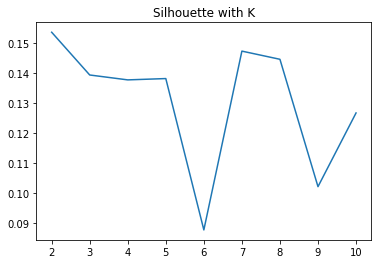

In [61]:
plt.plot(k_list, silhouette_list)
plt.title('Silhouette with K')
plt.show()

The Silhouette show its stable with k = [3,5]

In [22]:
print(sil_str)

With k = 2-Set Sum of Squared Erroes = 0.1536531494197656
With k = 3-Set Sum of Squared Erroes = 0.1393895244774296
With k = 4-Set Sum of Squared Erroes = 0.1377557701572319
With k = 5-Set Sum of Squared Erroes = 0.13819486880633444
With k = 6-Set Sum of Squared Erroes = 0.0876893888737683
With k = 7-Set Sum of Squared Erroes = 0.147355210024006
With k = 8-Set Sum of Squared Erroes = 0.1446271322567825
With k = 9-Set Sum of Squared Erroes = 0.10212502102923687
With k = 10-Set Sum of Squared Erroes = 0.12671587986786131



In this case, I will take k = 4 for clustering

In [114]:
kmeans = KMeans(featuresCol = 'features', k=3)
model = kmeans.fit(final_data)

In [115]:
predictions = model.transform(final_data)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print('Silhoutte = ' + str(silhouette))

Silhoutte = 0.1393895244774296


In [116]:
#show result
centers = model.clusterCenters()
print('Cluster Centers: ')
for center in centers:
    print(center)

Cluster Centers: 
[0.40922697 0.25579588 0.33153032 ... 0.         0.         0.        ]
[0.52298655 0.23905699 0.60978475 ... 0.         0.         0.        ]
[0.14877629 0.89652739 0.47544553 ... 0.         0.         0.        ]


In [117]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         2|
|         0|
|         0|
|         2|
|         2|
+----------+
only showing top 5 rows



In [118]:
predictions.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 2922|
|         1|   81|
|         2|  563|
+----------+-----+



- The result showed that 4 group have an imbalanced cluster value. 
- Group 1 have the most result with 2.7k.
- Next is group 2 with 500 and the rest are group 0 and 3

In [119]:
predictions.show(5)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(2471,[0,9,17,37,...|         2|
|(2471,[1,5,13,22,...|         0|
|(2471,[1,2,4,27,3...|         0|
|(2471,[1,26,28,83...|         2|
|(2471,[1,8,61,73,...|         2|
+--------------------+----------+
only showing top 5 rows



In [120]:
data_result = predictions.select('prediction')

### Plot the result with Scatter plot

Now I will plot the result to see if group of cluster overlapping or not.

In [121]:
from pyspark.ml.feature import PCA

In [122]:
pca = PCA(k = 2, inputCol = 'features', outputCol = 'pca') #k = n_components
model = pca.fit(predictions)

In [123]:
transformed = model.transform(predictions)

In [124]:
transformed.select(['prediction', 'pca']).show(3, truncate = False)

+----------+-----------------------------------------+
|prediction|pca                                      |
+----------+-----------------------------------------+
|2         |[-0.306446145082192,0.44349071688752617] |
|0         |[-0.11466794116984427,0.2140334184551736]|
|0         |[-0.71344050185208,-0.4756364624966698]  |
+----------+-----------------------------------------+
only showing top 3 rows



In [125]:
temp = transformed.select('pca').rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [126]:
temp.show(3)

+--------------------+-------------------+
|                  _1|                 _2|
+--------------------+-------------------+
|  -0.306446145082192|0.44349071688752617|
|-0.11466794116984427| 0.2140334184551736|
|   -0.71344050185208|-0.4756364624966698|
+--------------------+-------------------+
only showing top 3 rows



In [127]:
import pyspark.sql.functions as f

In [128]:
temp = temp.withColumn('row_index', f.monotonically_increasing_id())
data_result = data_result.withColumn('row_index', f.monotonically_increasing_id())
temp = temp.join(data_result, on = ['row_index']).sort('row_index').drop('row_index')

In [129]:
temp.show(3)

+--------------------+-------------------+----------+
|                  _1|                 _2|prediction|
+--------------------+-------------------+----------+
|  -0.306446145082192|0.44349071688752617|         2|
|-0.11466794116984427| 0.2140334184551736|         0|
|   -0.71344050185208|-0.4756364624966698|         0|
+--------------------+-------------------+----------+
only showing top 3 rows



In [130]:
temp = temp.select(col('_1').alias('x_scale'),
                  col('_2').alias('y_scale'),'prediction')

In [131]:
df = temp.toPandas()

In [132]:
df.head()

,x_scale,y_scale,prediction
0,-0.306446,0.443491,2
1,-0.114668,0.214033,0
2,-0.713441,-0.475636,0
3,-0.054363,0.572421,2
4,0.253009,0.596399,2


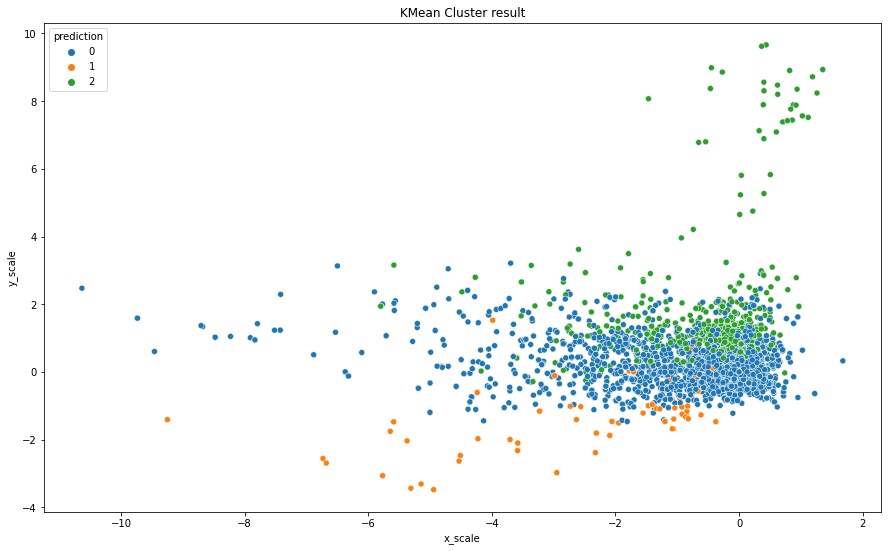

In [133]:
plt.figure(figsize = (15,9))
sns.scatterplot(x = 'x_scale', y = 'y_scale', hue = 'prediction', palette = 'tab10',data = df)
plt.title('KMean Cluster result')
plt.show()

The cluster groups are overlapping, now we will see what words does cluster group contain in order to know the type/topic of every cluster,

### Word Cloud

In [141]:
words = data.select('description_stopword')

I will concat the text value of every row of description_stopword feature

In [142]:
words = words.withColumn("description", concat_ws(" ", "description_stopword"))

In [143]:
words = words.withColumn('row_index', f.monotonically_increasing_id())
data_result = data_result.withColumn('row_index', f.monotonically_increasing_id())
words = words.join(data_result, on = ['row_index']).sort('row_index').drop('row_index')

In [144]:
words = words.toPandas()

In [145]:
words.head()

,description_stopword,description,prediction
0,"[canadian, pharmacies, limiting, much, medicat...",canadian pharmacies limiting much medication d...,2
1,"[yukon, government, identified, two, places, w...",yukon government identified two places whiteho...,0
2,"[senate, passed, unparalleled, trillion, econo...",senate passed unparalleled trillion economic r...,0
3,"[scientists, around, world, racing, find, nove...",scientists around world racing find novel ways...,2
4,"[latest, coronavirus, outbreak, cbc, news, thu...",latest coronavirus outbreak cbc news thursday ...,2


In [146]:
words.prediction.unique()

array([2, 0, 1])

I will filter the cluster group in to a single dataframe, then I will join all the text rows in every dataframe to create a text paragraph. => Draw a words cloud

In [147]:
cluster0 = ' '.join(words.description[words.prediction == 0])
cluster1 = ' '.join(words.description[words.prediction == 1])
cluster2 = ' '.join(words.description[words.prediction == 2])
#cluster3 = ' '.join(words.description[words.prediction == 3])
#cluster4 = ' '.join(words.description[words.prediction == 4])

In [148]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#### Group0

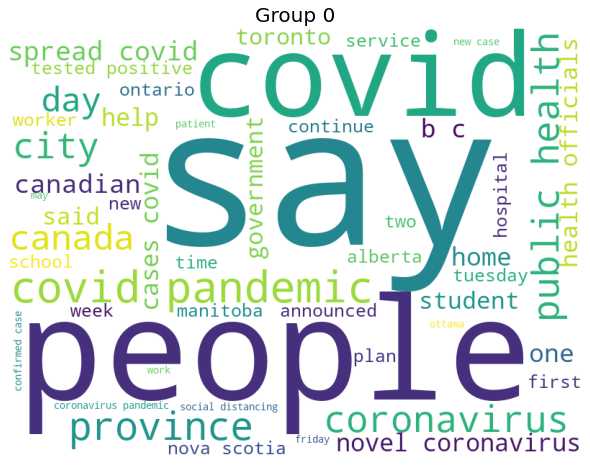

In [149]:
wordcloud = WordCloud(width = 800, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10, max_words=50).generate(cluster0)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Group 0', size = 20)
plt.tight_layout(pad = 0)

Group 0 contain the covid information such as confirm cases, total number, health, coronavirus. Or we can say it contain a general information about covid news in a specific place such as canadian, toronto, city => big city news

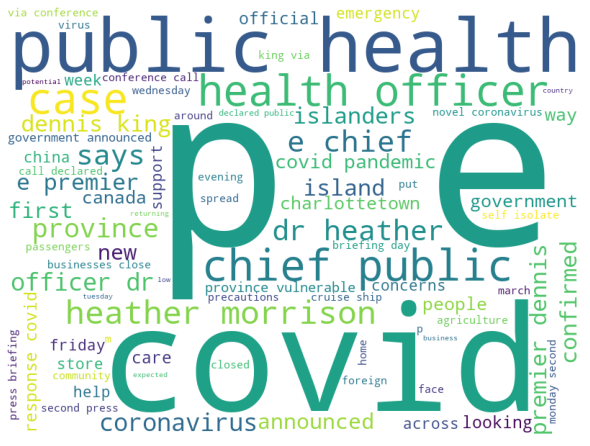

In [150]:
wordcloud = WordCloud(width = 800, height = 600,
                background_color ='white',
                      stopwords = stopwords,
                min_font_size = 10, max_words=80).generate(cluster1)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

The second cluster contain a information about covid too but target at public health, emergency, and also with specific place such as island, province, charlottetown. (the first group is covid new in big city) => smaller place news

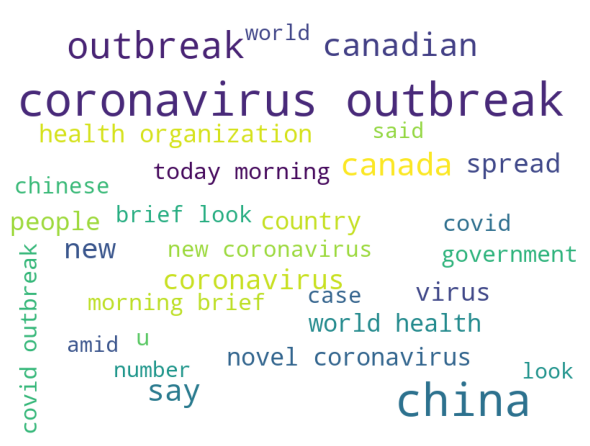

In [152]:
wordcloud = WordCloud(width = 800, height = 600,
                background_color ='white',
                      stopwords = stopwords,
                min_font_size = 10, max_words=30).generate(cluster2)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

- The final cluster contain a covid news relative with outbreaks, spread, world health, health organization and specific place like China.
- It showed that this cluster talk about the announcement about covid new around the world with the topic about case, spreading and outbreak.

### Conclusion:
- The model KMean have sucessfully divide a text feature into 3 cluster group, althought those 3 groups still have the same topic (covid) but it can showed its difference: first - big city news, second - small city/town news, third - world covid news.
- The KMean model is not the best algorithms for text clustering because the groups are overlapping and it performed badly on highly dimensional dataset. So I would suggest try with LDA instead.
- In this dataset, I already reduce the number of feature after transformation by using minDF and maxDF in CountVec function. If I did not use, the dataset feature after transformation will increased to 20k column, and it make KMean's performance badly.
- So that I decided to user those 2 param for a better result.